# Выбор локации для скважины

## Введение

<font color='navy'><b><u>Целевая задача Заказчика</b></u><i> - определение региона, с наибольшим уровнем прибыльности и наименьшим риском убытка, определенным по 200 лучшим скважинам</i><br>

<Font color='navy'><b><i><u>Цель исследования </b></i></u>- разработка модели прогноза среднего запасов скважин, определение наиболее эффективного региона добычи

<Font color='navy'><b><i><u>Задачи исследования</b></i></u><br>&nbsp;&nbsp;&nbsp;1. построить модель, которая сможет предсказать средний уровень запасов скважины в регионе<br>&nbsp;&nbsp;&nbsp;2. с помощью метода Bootstrap проанализировать доходность скважин региона и опередлить наиболее прибыльный регион с наименьшим риском убытка<br>

<Font color='navy'><b><i><u>План работы</b></i></u><br>
<Font color='navy'>1. загрузка, обзор, предобработка, и анализ данных<br>
<Font color='navy'>2. построение модели, которая поможет определить регион, где добыча принесёт наибольшую прибыль<br>
<Font color='navy'>3. расчет точки безубыточности для разработки скважины и средней прибыльности среди 200 отобранных лучших скважин по регионам<br>

## Загрузка, обзор и подготовка данных

### Загрузка библиотек

In [10]:
# импорт основных библиотек
import os
import pandas as pd
import numpy as np
from scipy import stats as st
import sklearn
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.simplefilter("ignore")

# импорт модулей для разделения данных и создания моделей МО
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# импорт модуля для построения Pipeline
from sklearn.pipeline import Pipeline

# импорт модулей для масштабирования и кодирования
from sklearn.preprocessing import StandardScaler

# импорт модулей для расчета метрик
from sklearn.metrics import (mean_squared_error, 
                            mean_absolute_error, 
                            r2_score)

# импорт библиотек для визуализации
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

In [11]:
print('Версии библиотек, которые установлены у меня в окружении')
print('Версия pandas', pd.__version__)
print('Версия numpy', np.__version__)
print('Версия seaborn', sns.__version__)
print('Версия matplotlib', matplotlib.__version__)
print('Версия sklearn', sklearn.__version__)

Версии библиотек, которые установлены у меня в окружении
Версия pandas 2.2.2
Версия numpy 1.26.4
Версия seaborn 0.13.2
Версия matplotlib 3.8.4
Версия sklearn 1.4.2


### Загрузка данных

In [13]:
# функция для обзора данных
def display_df_info(data):
    display(data.head(5))
    print('-'*100)
    data.info()
    print('-'*100)
    print('Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('Дубликаты записей не выявлены')
    
    if data.isnull().sum().sum() != 0:
            try:
                (data.isna().mean()*100).to_frame() \
                .rename(columns = {0:'space'}) \
                .query('space > 0') \
                .sort_values(by = 'space', ascending = True) \
                .plot(kind = 'barh', figsize = (8, 2), legend = False, fontsize = 7, color='royalblue', \
                      title ='Пропущенные значения, %', \
                      xlabel = 'Процент пропусков', \
                      ylabel='Столбцы с пропусками', \
                      grid=True, style='-',)
                plt.show();    
            except:
                print('Пропусков данных нет')
    else:
        print('Пропусков данных нет')

In [21]:
# загрузим предоставленные датасеты
## данные региона 1. 
pth1 = 'C:\\Data_Science\\projects\\oil\\geo_data_0.csv'
## данные региона 2
pth2 = 'C:\\Data_Science\\projects\\oil\\geo_data_1.csv'
## данные региона 3
pth3 = 'C:\\Data_Science\\projects\\oil\\geo_data_2.csv'


if os.path.exists(pth1):
    df_1 = pd.read_csv(pth1)
else:
    print(f'Something is wrong with pth1')
if os.path.exists(pth2):
    df_2 = pd.read_csv(pth2)
else:
    print(f'Something is wrong with pth2')
if os.path.exists(pth3):
    df_3 = pd.read_csv(pth3)
else:
    print(f'Something is wrong with pth3')




#df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', sep=',', decimal=".")
## данные региона2
#df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', \
                          #  sep=',', decimal=".")
## данные региона 3. 
#df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', \
                                      #          sep=',', decimal=".", thousands=',')

In [23]:
display_df_info(df_1)

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------------------------------------------------------
Количество столбцов - 5, количество записей - 100000
Дубликаты записей не выявлены
Пропусков данных нет


In [25]:
print('Уникальных id скважин в датасете `geo_data_0`', df_1['id'].nunique())

Уникальных id скважин в датасете `geo_data_0` 99990


In [27]:
dubl_data_1 = df_1.groupby('id').agg({'f0': 'count'}).reset_index().sort_values(by='f0', ascending=False).query('f0 > 1')
print('Перечень скважин, по которым в датасете представлено более одного варианта характеристик \n', list(dubl_data_1['id']))

Перечень скважин, по которым в датасете представлено более одного варианта характеристик 
 ['Tdehs', 'bxg6G', 'QcMuo', 'HZww2', 'TtcGQ', 'AGS9W', 'fiKDv', 'bsk9y', 'A5aEY', '74z30']


<Font color='navy'>Датасет <b>`geo_data_0`</b> содержит 5 колонок 100,000 записей данных о скважинах<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `id` — уникальный идентификатор скважины, тип данных obj - соответствует описанию, пропусков данных нет, в датасете пресдставлены данные о 99,990 уникальных скважинах<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `f0`, `f1`, `f2` — характеристики скважин, тип данных float - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `product` — объем запасов, тип данных float - соответствует описанию, пропусков данных нет<br>

In [30]:
display_df_info(df_2)

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------------------------------------------------------
Количество столбцов - 5, количество записей - 100000
Дубликаты записей не выявлены
Пропусков данных нет


In [32]:
print('Уникальных id скважин в датасете `geo_data_1`', df_2['id'].nunique())

Уникальных id скважин в датасете `geo_data_1` 99996


In [34]:
dubl_data_2 = df_2.groupby('id').agg({'f0': 'count'}).reset_index().sort_values(by='f0', ascending=False).query('f0 > 1')
print('Перечень скважин, по которым в датасете представлено более одного варианта характеристик \n', list(dubl_data_2['id']))

Перечень скважин, по которым в датасете представлено более одного варианта характеристик 
 ['wt4Uk', 'LHZR0', '5ltQ6', 'bfPNe']


<Font color='navy'>Датасет <b>`geo_data_1`</b> содержит 5 колонок 100,000 записей данных о скважинах<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `id` — уникальный идентификатор скважины, тип данных obj - соответствует описанию, пропусков данных нетб в датасете пресдставлены данные о 99,996 уникальных скважинах<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `f0`, `f1`, `f2` — характеристики скважин, тип данных float - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `product` — объем запасов, тип данных float - соответствует описанию, пропусков данных нет<br>

In [37]:
display_df_info(df_3)

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------------------------------------------------------
Количество столбцов - 5, количество записей - 100000
Дубликаты записей не выявлены
Пропусков данных нет


In [39]:
print('Уникальных id скважин в датасете `geo_data_2`', df_3['id'].nunique())

Уникальных id скважин в датасете `geo_data_2` 99996


In [41]:
dubl_data_3 = df_3.groupby('id').agg({'f0': 'count'}).reset_index().sort_values(by='f0', ascending=False).query('f0 > 1')
print('Перечень скважин, по которым в датасете представлено более одного варианта характеристик \n', list(dubl_data_3['id']))

Перечень скважин, по которым в датасете представлено более одного варианта характеристик 
 ['xCHr8', 'KUPhW', 'Vcm5J', 'VF7Jo']


<Font color='navy'>Датасет <b>`geo_data_2`</b> содержит 5 колонок 100,000 записей данных о скважинах<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `id` — уникальный идентификатор скважины, тип данных obj - соответствует описанию, пропусков данных нет, в датасете пресдставлены данные о 99,996 уникальных скважинах<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `f0`, `f1`, `f2` — характеристики скважин, тип данных float - соответствует описанию, пропусков данных нет<br>
<Font color='navy'>&nbsp;&nbsp;&nbsp;- `product` — объем запасов, тип данных float - соответствует описанию, пропусков данных нет<br>

### Анализ данных

In [45]:
# напишем функцю для визуализации распределения данных
def continuous_data_plot(df, column):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'распределение признака "{column}"', color = 'navy')
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column, facecolor = 'lightsteelblue', \
                 color='navy',edgecolor='navy', \
                 stat='density', common_norm=False, kde=True)
    median_value = df[column].median()
    mean_value = df[column].mean()
    plt.axvline(median_value, color='maroon', linestyle='--', label=f'Median: {median_value:.2f}')
    plt.axvline(mean_value, color='gold', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.xlabel(f'значения "{column}"', color = 'navy')
    plt.xticks(color='navy', fontsize=7)
    plt.ylabel('плотность распределения', color = 'navy')
    plt.yticks(color='navy', fontsize=7)
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, y=column, color='lightsteelblue', fill=True, \
                gap=.1, width=.75, linecolor='navy')
    plt.ylabel(f'значение "{column}"', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')
    
    plt.show()

#### Анализ данных региона 1

In [48]:
df_1.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
12.5%,-0.70,-0.41,-1.29,36.81
50%,0.50,0.25,2.52,91.85
87.5%,1.70,0.91,6.28,148.40
max,2.36,1.34,16.00,185.36


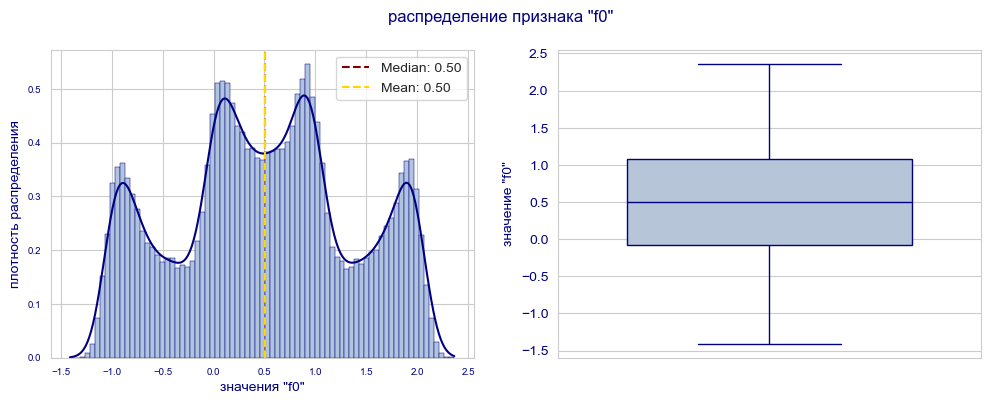

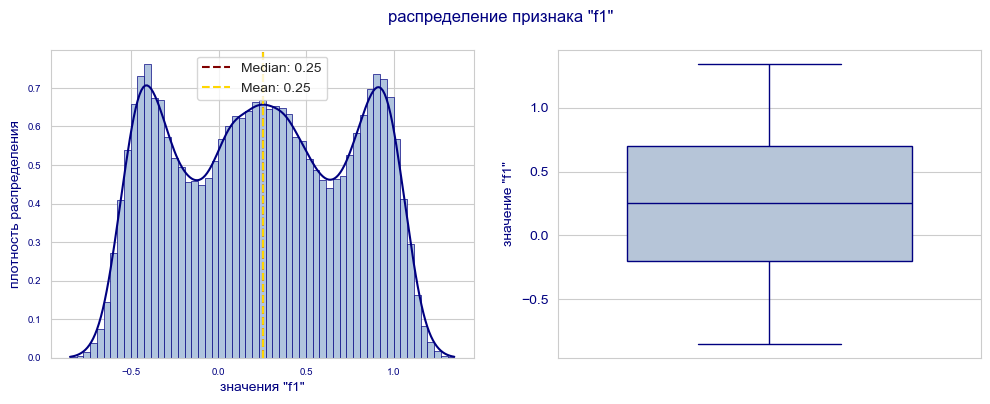

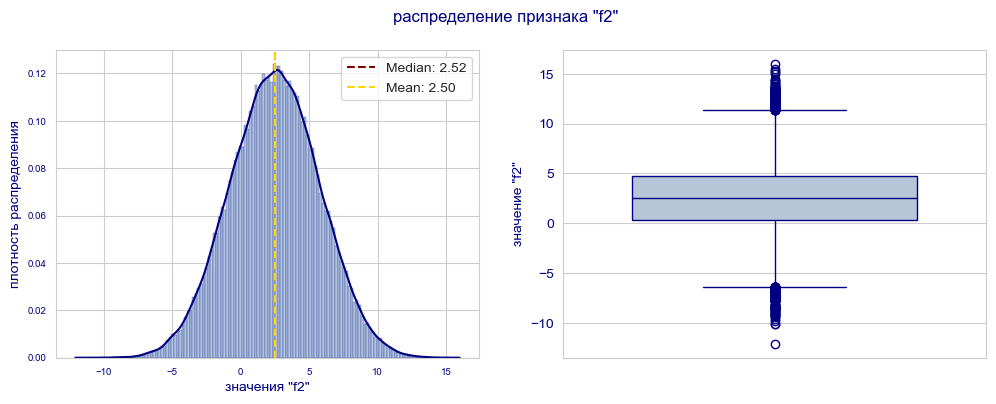

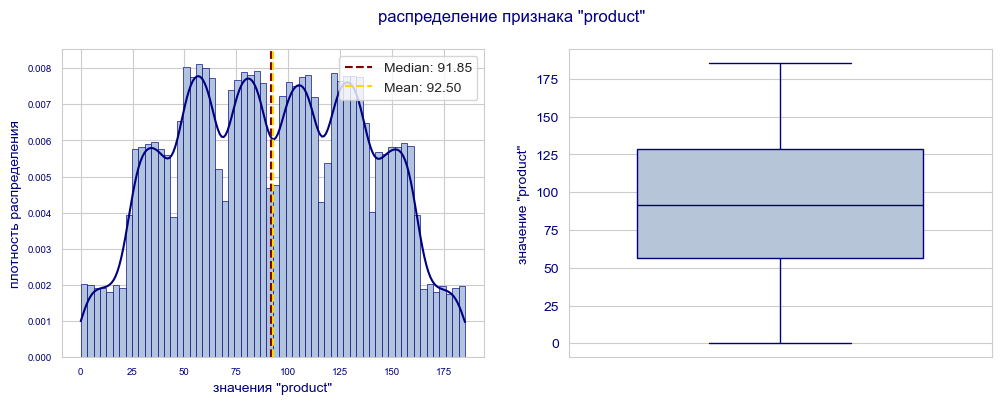

In [47]:
for column in list(df_1.drop('id',axis=1).columns):
    continuous_data_plot(df_1, column)

<font color='Darkblue'><b><u>распределение признаков в датасете df_1</b></u><br>&nbsp;&nbsp;&nbsp;<b><u>`f0`</b></u> - распределение мультимодальное (4 пика), без выбросов, 75% значений находится в диапазоне от (0.70) до 1.70, медиана и среднее знаения совпадают - 0.5 </b><br>  &nbsp;&nbsp;&nbsp;<b><u>`f1`</b></u> - распределение мультимодальное (3 пика), без выбросов, 75% значений находится в диапазоне от (0.41) до 0.91, медиана и среднее знаения совпадают - 0.25 </b><br>&nbsp;&nbsp;&nbsp;<b><u>`f2`</b></u> - распределение нормальное, наблюдается значительное количество выбросов, 75% значений находится в диапазоне от (1.29) до 6.28, медиана и среднее знаения почти совпадают - 2.52 и 2.50 </b><br>&nbsp;&nbsp;&nbsp;<b><u>`product` - <i>целевой признак</i></b></u> - распределение мультимодальное (6 пиков), без выбросов, 75% значений находится в диапазоне от 36.81 до 148.40, медиана и среднее знаения почти совпадают - 91.85 и 92.50 </b><br
<font color='Darkblue'><i><b> В данных наблюдается значительное количество выбросов значений признака f2, но удалять их нельзя, поэтому нормализуем их в рамках подготовки данных 

In [50]:
# посмотрим насколько задублированные данные по скважинам выбиваются из общей массы
dubl_df_1 = df_1[df_1['id'].isin(list(dubl_data_1['id']))].sort_values(by='id')
display(dubl_df_1)
# поскольку выбросы наблюдаются только по f2 посмотрим оказались ли некорректные данные среди выбросов
if dubl_df_1['f2'].min() < -6 or dubl_df_1['f2'].max() > 11:
    print('некорректные данные о скважинах присутсвуют в выбросах признака f2')
else:
   print('некорректные данные о скважинах отсутсвуют в выбросах признака f2') 

,id,f0,f1,f2,product
66136,74z30,1.08,-0.31,6.99,127.64
64022,74z30,0.74,0.46,5.15,140.77
51970,A5aEY,-0.18,0.94,-2.09,33.02
3389,A5aEY,-0.04,0.16,0.21,89.25
69163,AGS9W,-0.93,0.12,-3.66,19.23
42529,AGS9W,1.45,-0.48,0.68,126.37
931,HZww2,0.76,0.37,1.86,30.68
7530,HZww2,1.06,-0.37,10.43,158.83
63593,QcMuo,0.64,-0.47,0.86,64.58
1949,QcMuo,0.51,-0.32,-2.22,75.50


некорректные данные о скважинах отсутсвуют в выбросах признака f2


<font color='Darkblue'> Анализ данных о скважинах, по которым в данных представлено более одной строчки данных говорит о том, что скорее всего это техническая ошибка: вероятно из предоставленных данных не удалены первоначальные данные, которые были позднее скорретированы. Но, поскольку мы не обладаем 100% информацией о природе возникновения подобных данных, при этом их количество, относительно всех данных по скважинам региона невелико, удалим данные о 10 скважинах из анализируемого датасета.

In [53]:
df_1 = df_1[~df_1['id'].isin(list(dubl_data_1['id']))]
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


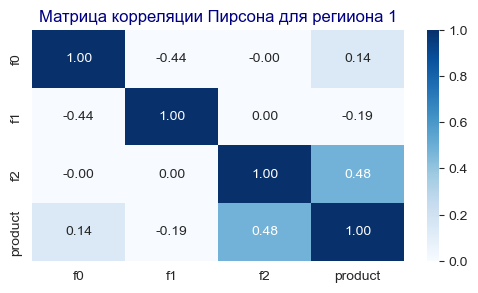

In [55]:
# посмотрим на корреляцию Пирсона
corr_matrix = df_1.drop('id', axis = 1).corr()
plt.figure(figsize=(6,3))
sns.heatmap(corr_matrix, annot = True, cmap='Blues', vmin=0, vmax=1, fmt='.2f')
plt.title('Матрица корреляции Пирсона для регииона 1', color='navy')
plt.show()

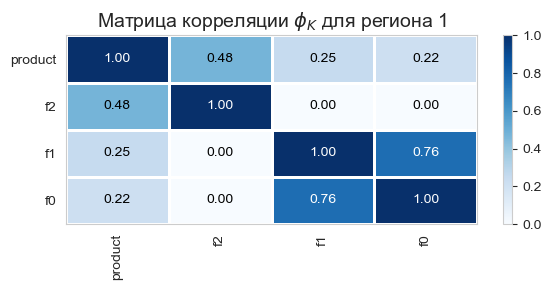

In [83]:
# считаем корреляцию ФиКа
phik_overview_df_1 = phik_matrix(df_1.drop('id', axis=1), interval_cols=df_1.columns) 
# построим матрицу корреляции для признаков
plot_correlation_matrix(
    phik_overview_df_1.values,
    x_labels=phik_overview_df_1.columns,
    y_labels=phik_overview_df_1.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$ для региона 1',
    fontsize_factor=1,
    figsize=(6, 3)
) 

<font color='Darkblue'><i> Признаки скважин для региона 1 имеют либо слабую, либо очень слабую линейную корреляцию. При этом наблюдается высокая нелинейная корреляци признаков f1 и f0

In [86]:
# резюме данных региона 1
data_1 = [
    ['f0_1', 'мультимод.(4 пика)', 'нет', 'от (0.70) до 1.70', '0.50', '0.50', 'высокая c f1'],
    ['f1_1', 'мультимод.(3 пика)', 'нет', 'от (0.41) до 0.91', '0.25', '0.25', 'высокая c f0'],
    ['f2_1', 'нормальное', 'много', 'от (01.29) до 0.28', '2.52', '2.50', 'слабая c product'],
    ['product_1', 'мультимод.(6 пиков)', 'нет', 'от 36.81 до 148.40', '91.85', '92.50', 'слабая с f2']
]
df_1_overview = pd.DataFrame(data_1, columns=['feature', 'distribution', 'outlier', '75%_values', 'median', 'mean', 'corr'])
df_1_overview

,feature,distribution,outlier,75%_values,median,mean,corr
0,f0_1,мультимод.(4 пика),нет,от (0.70) до 1.70,0.50,0.50,высокая c f1
1,f1_1,мультимод.(3 пика),нет,от (0.41) до 0.91,0.25,0.25,высокая c f0
2,f2_1,нормальное,много,от (01.29) до 0.28,2.52,2.50,слабая c product
3,product_1,мультимод.(6 пиков),нет,от 36.81 до 148.40,91.85,92.50,слабая с f2


#### Анализ данных региона 2

In [89]:
df_2.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

,f0,f1,f2,product
count,"99,991.00","99,991.00","99,991.00","99,991.00"
mean,1.14,-4.80,2.49,68.82
std,8.97,5.12,1.70,45.94
min,-27.83,-26.36,-0.02,0.00
12.5%,-9.64,-10.70,0.00,3.18
50%,1.15,-4.81,2.01,57.09
87.5%,11.92,1.11,5.00,134.77
max,29.42,18.73,5.02,137.95


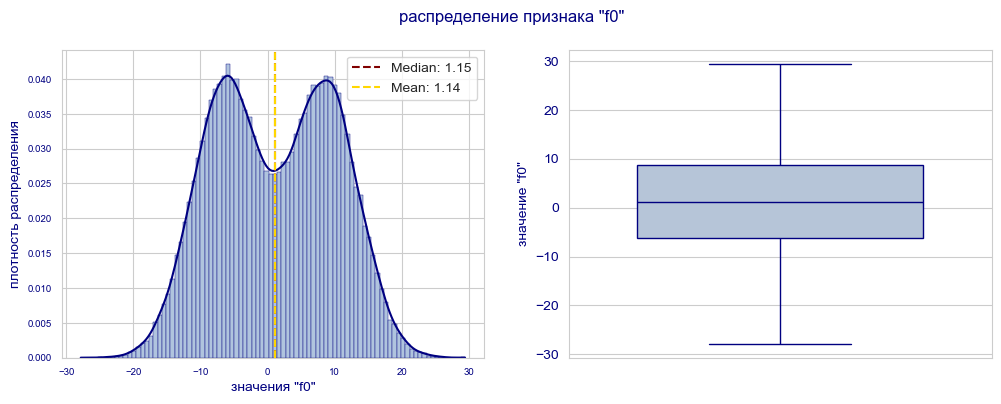

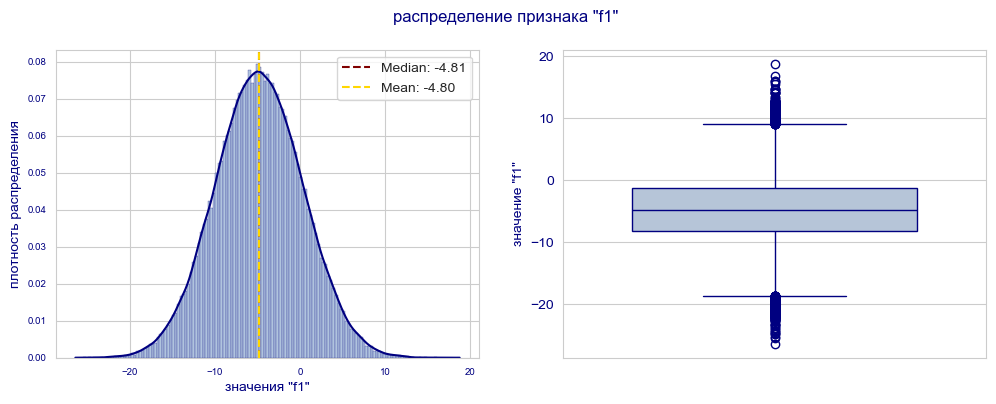

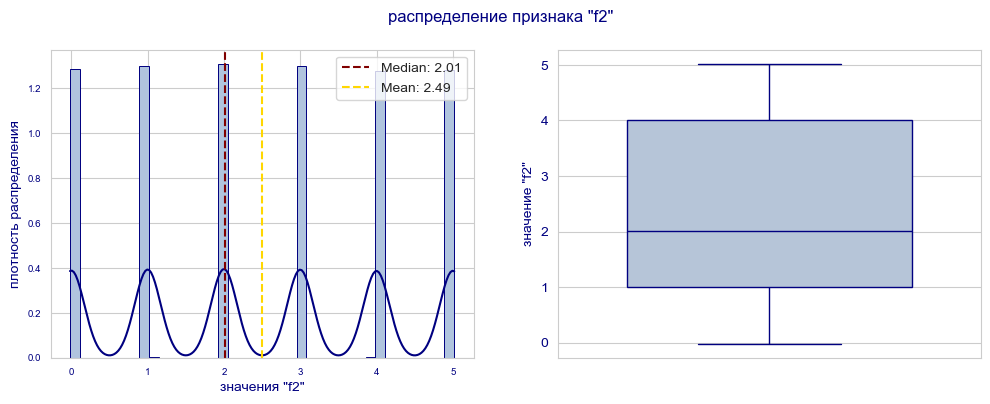

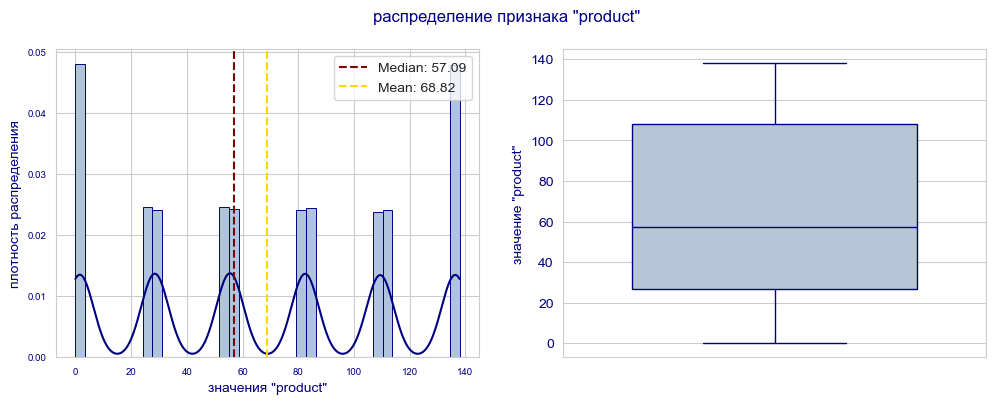

In [91]:
for column in list(df_1.drop('id',axis=1).columns):
    continuous_data_plot(df_2, column)

<font color='Darkblue'><b><u>распределение признаков в датасете df_2</b></u><br>&nbsp;&nbsp;&nbsp;<b><u>`f0`</b></u> - распределение бимодальное, есть один вывброс - (31.61), 75% значений находится в диапазоне от (9.64) до 11.92, медиана и среднее знаения почти совпадают - 1.11 и 1.14 </b><br>  &nbsp;&nbsp;&nbsp;<b><u>`f1`</b></u> - распределение нормальное, наблюдается значительное количество выбросов, 75% значений находится в диапазоне от (10.70) до 1.11, медиана и среднее знаения почти совпадают - (4.81) и (4.80) </b><br>&nbsp;&nbsp;&nbsp;<b><u>`f2`</b></u> - распределение дискретное, все данные сконцентрированы вокруг 6 значений показателя: 0, 1, 2, 3, 4 и 5, выбросов нет, 75% значений находится в диапазоне от 0 до 5, медиана и среднее знаения близки по значению - 2.01 и 2.49 соответственно </b><br>&nbsp;&nbsp;&nbsp;<b><u>`product` - <i>целевой признак</i></b></u> - распределение дискретное, четко-выраженная концентрация значений вокруг 6 нешироких диапазонов значений запасов, выбросов нет, 75% значений находится в диапазоне от 3.18 до 134.77, медиана и среднее знаения различаются - 57.09 и 68.83 соответственно </b><br>
<font color='Darkblue'><i><b> В данных наблюдается выброс значения признака f0, который очевидно является аномальным, и его стоит удалить из данных, а также значительное количество выбросов значений признака f1, но их удалять нельзя, поэтому нормализуем их в рамках подготовки данных 

In [93]:
df_2 = df_2.query('f0 > -30')

In [94]:
# посмотрим насколько задублированные данные по скважинам выбиваются из общей массы
dubl_df_2 = df_2[df_2['id'].isin(list(dubl_data_2['id']))].sort_values(by='id')
display(dubl_df_2)
# поскольку выбросы наблюдаются только по f2 посмотрим оказались ли некорректные данные среди выбросов
if dubl_df_2['f1'].min() < -19 or dubl_df_2['f1'].max() > 9:
    print('некорректные данные о скважинах присутсвуют в выбросах признака f2')
else:
   print('некорректные данные о скважинах отсутсвуют в выбросах признака f2') 

,id,f0,f1,f2,product


некорректные данные о скважинах отсутсвуют в выбросах признака f2


<font color='Darkblue'> Анализ данных о скважинах региона 2, по которым в данных представлено более одной строчки данных говорит о том, что скорее всего, как и в первом регионе, это техническая ошибка: вероятно из предоставленных данных не удалены первоначальные данные, которые были позднее скорретированы. Но, поскольку мы не обладаем 100% информацией о природе возникновения подобных данных, при этом их количество, относительно всех данных по скважинам региона невелико, удалим данные о 4 скважинах из анализируемого датасета.

In [99]:
df_2 = df_2[~df_2['id'].isin(list(dubl_data_2['id']))]
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99991 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99991 non-null  object 
 1   f0       99991 non-null  float64
 2   f1       99991 non-null  float64
 3   f2       99991 non-null  float64
 4   product  99991 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


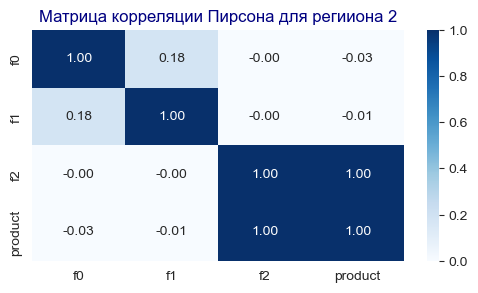

In [101]:
# посмотрим на корреляцию Пирсона
corr_matrix = df_2.drop('id', axis = 1).corr()
plt.figure(figsize=(6,3))
sns.heatmap(corr_matrix, annot = True, cmap='Blues', vmin=0, vmax=1, fmt='.2f')
plt.title('Матрица корреляции Пирсона для регииона 2', color='navy')
plt.show()

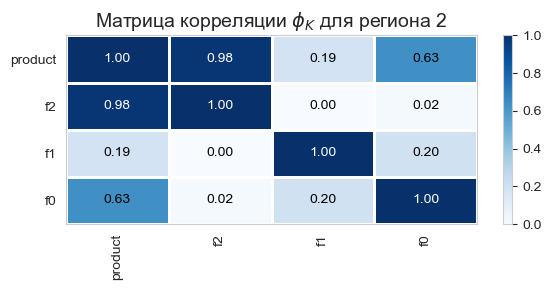

In [102]:
# считаем корреляцию для признаков ФиКа
phik_overview_df_2 = phik_matrix(df_2.drop('id', axis=1), interval_cols=df_2.columns) 
# построим матрицу корреляции для признаков первой задачи
plot_correlation_matrix(
    phik_overview_df_2.values,
    x_labels=phik_overview_df_2.columns,
    y_labels=phik_overview_df_2.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$ для региона 2',
    fontsize_factor=1,
    figsize=(6, 3)
) 

<font color='Darkblue'><i> Признак f2 и объем запасов скважин для региона 2 имеют очень высокую корреляцию: вероятно, это связаано с осбенностями данных по этому региону, т.к. предположить утечку данных в данном случае нельзя. Линейная корреляционна зависимость остальных признаков очень слабая. Нелинейная взаимосвязь, хотя и среднего уровня выявлена между признаком f0 и запасами.

In [105]:
# резюме данных региона 2
data_2 = [
    ['f0_2', 'бимодальное', 'один, удален', 'от (9.64) до 11.92', '1.11', '1.14', 'средняя с product'],
    ['f1_2', 'нормальное', 'много', 'от (10.70) до 1.11', '4.81', '4.80', 'слабая'],
    ['f2_2', 'дискретное', 'нет', 'от 0.0 до 5.0', '2.01', '2.49', 'очень высокая c product'],
    ['product_2', 'дискретное', 'нет', 'от 3.18 до 134.77', '57.09', '68.83', 'очень высокая с f2']
]
df_2_overview = pd.DataFrame(data_2, columns=['feature', 'distribution', 'outlier', '75%_values', 'median', 'mean', 'corr'])
df_2_overview

,feature,distribution,outlier,75%_values,median,mean,corr
0,f0_2,бимодальное,"один, удален",от (9.64) до 11.92,1.11,1.14,средняя с product
1,f1_2,нормальное,много,от (10.70) до 1.11,4.81,4.80,слабая
2,f2_2,дискретное,нет,от 0.0 до 5.0,2.01,2.49,очень высокая c product
3,product_2,дискретное,нет,от 3.18 до 134.77,57.09,68.83,очень высокая с f2


#### Анализ данных региона 3

In [109]:
df_3.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
12.5%,-1.99,-1.99,-1.52,38.81
50%,0.01,-0.01,2.48,94.93
87.5%,1.99,1.99,6.52,151.22
max,7.24,7.84,16.74,190.03


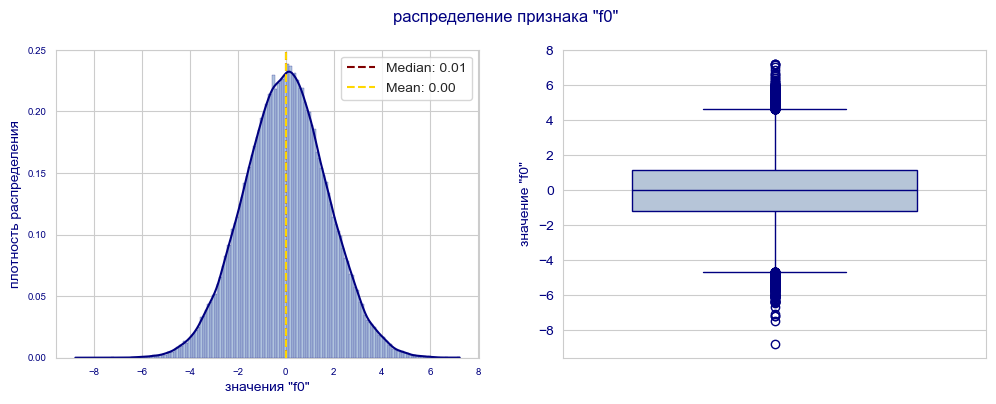

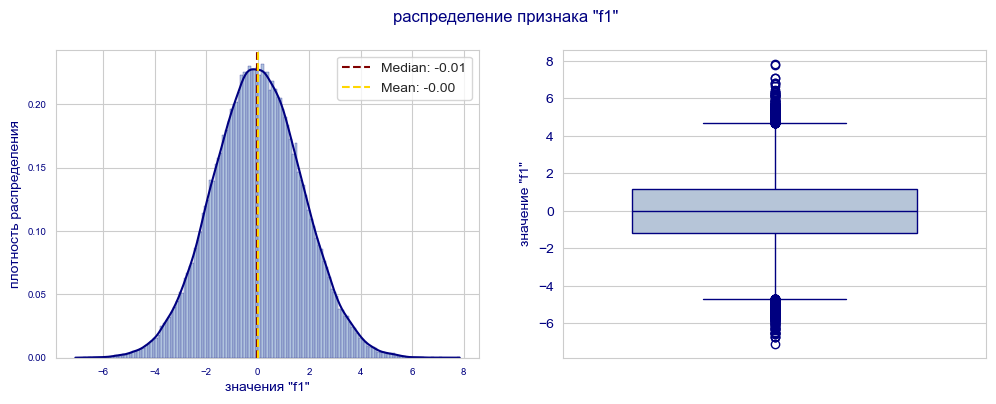

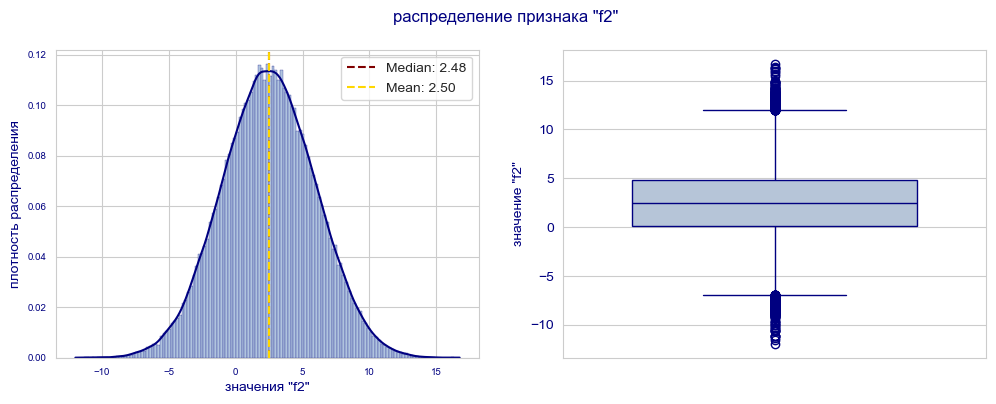

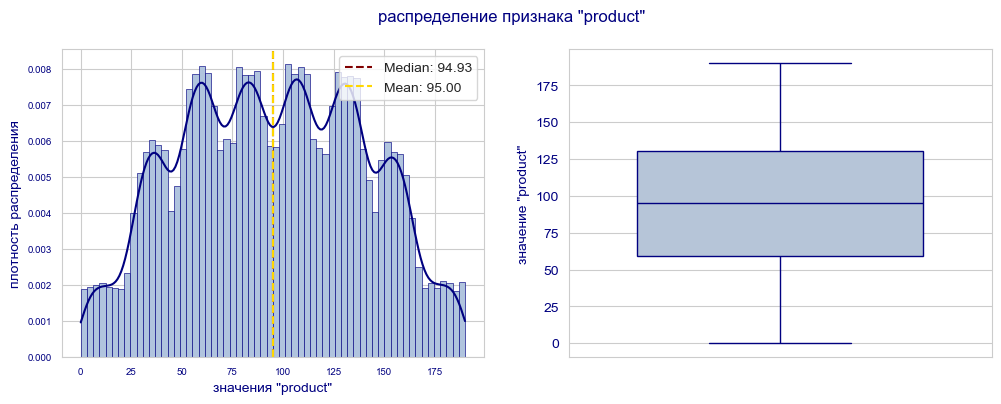

In [111]:
for column in list(df_3.drop('id',axis=1).columns):
    continuous_data_plot(df_3, column)

<font color='Darkblue'><b><u>распределение признаков в датасете df_3</b></u><br>&nbsp;&nbsp;&nbsp;<b><u>`f0`</b></u> - распределение нормальное, присутсвует много выбросов, 75% значений находится в небольшом диапазоне от (1.99) до 1.99, медиана и среднее знаения почти совпадают - 0.01 и 0.00 </b><br>  &nbsp;&nbsp;&nbsp;<b><u>`f1`</b></u> - распределение нормальное, присутсвует много выбросов, 75% значений находится в небольшом диапазоне от (1.99) до 1.99, медиана и среднее знаения почти совпадают - (0.01) и (0.00) </b><br>&nbsp;&nbsp;&nbsp;<b><u>`f2`</b></u> - распределение нормальное, присутсвует много выбросов, 75% значений находится в небольшом диапазоне от (1.52) до 6.52, медиана и среднее знаения почти совпадают - 2.48 и 2.50</b><br>&nbsp;&nbsp;&nbsp;<b><u>`product` - <i>целевой признак</i></b></u> - распределение мультимодальное (6 пиков), без выбросов, 75% значений находится в диапазоне от - 38.81 до 151.22, медиана и среднее знаения почти совпадают - 94.93 и 95.00 </b><br>
<font color='Darkblue'><i><b> По всем трем входным признакам датасета наблюдается значительное количество выбросов, но, как и в первых двух случаях, удалять их нельзя, поэтому также воспользуемся нормализацией в рамках подготовки данных 

In [113]:
# посмотрим насколько задублированные данные по скважинам выбиваются из общей массы
dubl_df_3 = df_3[df_3['id'].isin(list(dubl_data_3['id']))].sort_values(by='id')
display(dubl_df_3)
# поскольку выбросы наблюдаются только по f2 посмотрим оказались ли некорректные данные среди выбросов
if dubl_df_3['f0'].min() < -4.5 or dubl_df_3['f0'].max() > 4.5:
    print('некорректные данные о скважинах присутсвуют в выбросах признака f0')
else:
   print('некорректные данные о скважинах отсутсвуют в выбросах признака f0') 

if dubl_df_3['f1'].min() < -4.5 or dubl_df_3['f1'].max() > 4.5:
    print('некорректные данные о скважинах присутсвуют в выбросах признака f1')
else:
   print('некорректные данные о скважинах отсутсвуют в выбросах признака f1')

if dubl_df_3['f2'].min() < -7.0 or dubl_df_3['f2'].max() > 12.0:
    print('некорректные данные о скважинах присутсвуют в выбросах признака f2')
else:
   print('некорректные данные о скважинах отсутсвуют в выбросах признака f2')

,id,f0,f1,f2,product
45404,KUPhW,0.23,-1.70,4.99,11.72
55967,KUPhW,1.21,3.18,5.54,132.83
11449,VF7Jo,2.12,-0.86,5.75,181.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
44378,Vcm5J,-1.23,-2.44,1.22,137.97
95090,Vcm5J,2.59,1.99,2.48,92.33
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39


некорректные данные о скважинах отсутсвуют в выбросах признака f0
некорректные данные о скважинах отсутсвуют в выбросах признака f1
некорректные данные о скважинах отсутсвуют в выбросах признака f2


<font color='Darkblue'> Анализ данных о скважинах, по которым в данных представлено более одной строчки данных говорит о том, что как в 1 и 2 регионах, скорее всего это техническая ошибка. И, как и в предыдущих случаях, удалим данные о 4 скважинах из анализируемого датасета.

In [115]:
df_3 = df_3[~df_3['id'].isin(list(dubl_data_3['id']))]
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


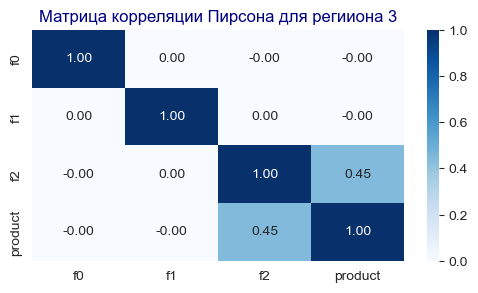

In [116]:
# считаем корреляцию Пирсона
corr_matrix = df_3.drop('id', axis = 1).corr()
plt.figure(figsize=(6,3))
sns.heatmap(corr_matrix, annot = True, cmap='Blues', vmin=0, vmax=1, fmt='.2f')
plt.title('Матрица корреляции Пирсона для регииона 3', color='navy')
plt.show()

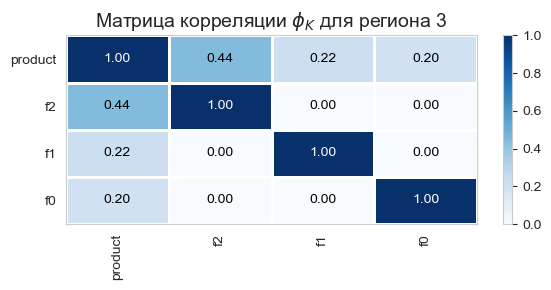

In [117]:
# считаем корреляцию для признаков
phik_overview_df_3 = phik_matrix(df_3.drop('id', axis=1), interval_cols=df_3.columns) 
# построим матрицу корреляции для признаков
plot_correlation_matrix(
    phik_overview_df_3.values,
    x_labels=phik_overview_df_3.columns,
    y_labels=phik_overview_df_3.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$ для региона 3',
    fontsize_factor=1,
    figsize=(6, 3)
) 

<font color='Darkblue'><i> Признаки скважин для региона 3 имеют либо слабую, либо очень слабую как ни линейную, так и ни нелинейную корреляцию

In [119]:
# резюме данных региона 3
data_3 = [
    ['f0_3', 'нормальное', 'много', 'от (1.99) до 1.99', '0.01', '0.00', 'очень слабая'],
    ['f1_3', 'нормальное', 'много', 'от (1.99) до 1.99', '(0.01)', '(0.00)', 'очень слабая'],
    ['f2_3', 'нормальное', 'много', 'от 0.0 до 5.0', '2.01', '2.49', 'очень слабая'],
    ['product_3', 'мультимод.(6 пиков)', 'нет', 'от 38.81 до 151.22', '94.93', '95.00', 'очень слабая']
]
df_3_overview = pd.DataFrame(data_3, columns=['feature', 'distribution', 'outlier', '75%_values', 'median', 'mean', 'corr'])
df_3_overview

,feature,distribution,outlier,75%_values,median,mean,corr
0,f0_3,нормальное,много,от (1.99) до 1.99,0.01,0.00,очень слабая
1,f1_3,нормальное,много,от (1.99) до 1.99,(0.01),(0.00),очень слабая
2,f2_3,нормальное,много,от 0.0 до 5.0,2.01,2.49,очень слабая
3,product_3,мультимод.(6 пиков),нет,от 38.81 до 151.22,94.93,95.00,очень слабая


### Резюме

<font color='Darkblue'><b><i> ✔️ Обзор данных</b></i><br>
<font color='Darkblue'>Для исследования предоставлено 3 датасэта, характеризующих пробы в скважинах трех регионов</u><br> &nbsp;&nbsp;&nbsp;<b>- все датасэты содержат по 5 колонок и 100,000 записей </b><br> &nbsp;&nbsp;&nbsp;<b>- `id`</b> — уникальный идентификатор скважины, тип данных obj, пропусков данных нет, в датасэте `df_1` предоставлены данные о 99,990 уникальных скважинах, в датасэтах `df_2` и `df_3` предоставлены данные о 99,996 уникальных скважинах<br> &nbsp;&nbsp;&nbsp;<b>- `f0`, `f1`, `f2`</b> — характеристики скважин, тип данных float, пропусков данных нет<br> &nbsp;&nbsp;&nbsp;<b>- `product`</b> — объем запасов, тип данных float, пропусков данных нет<br>

<font color='Darkblue'><b><i> ✔️ Анализ данных</b></i><br>
<font color='Darkblue'>Из анализа распределения данных следует, что<br>&nbsp;&nbsp;&nbsp;- распределение и корреляция признаков f0, f1 и f2 в данных по регионам существенно различается<br>&nbsp;&nbsp;&nbsp;- по распределению, диапазону значений, медианному и среднему значениям объемов запасов значения сопоставимы в 1 и 3 регионах 

In [129]:
df_overview = pd.concat([df_1_overview, df_2_overview, df_3_overview], axis=0, join='inner')
df_overview.sort_values(by='feature'). \
                style.set_caption("Ключевые показатели распределения признаков по регионам"). \
                set_table_styles([{'selector': 'caption','props': [('color', 'navy'),('font-size', '16px'), ('font-weight', 'bold')]}])

,feature,distribution,outlier,75%_values,median,mean,corr
0,f0_1,мультимод.(4 пика),нет,от (0.70) до 1.70,0.50,0.50,высокая c f1
0,f0_2,бимодальное,"один, удален",от (9.64) до 11.92,1.11,1.14,средняя с product
0,f0_3,нормальное,много,от (1.99) до 1.99,0.01,0.00,очень слабая
1,f1_1,мультимод.(3 пика),нет,от (0.41) до 0.91,0.25,0.25,высокая c f0
1,f1_2,нормальное,много,от (10.70) до 1.11,4.81,4.80,слабая
1,f1_3,нормальное,много,от (1.99) до 1.99,(0.01),(0.00),очень слабая
2,f2_1,нормальное,много,от (01.29) до 0.28,2.52,2.50,слабая c product
2,f2_2,дискретное,нет,от 0.0 до 5.0,2.01,2.49,очень высокая c product
2,f2_3,нормальное,много,от 0.0 до 5.0,2.01,2.49,очень слабая
3,product_1,мультимод.(6 пиков),нет,от 36.81 до 148.40,91.85,92.50,слабая с f2


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно. Радует, что распределения и корреляции были визуализированы!
</div>

## Обучение и проверка модели

In [133]:
# проверим наличие дубликатов данных без идентификатора скважины
print('В данных региона 1 (без id скважины) найдено {} дубликатов данных'.format(df_1.drop('id', axis=1).duplicated().sum()))
print('В данных региона 2 (без id скважины) найдено {} дубликатов данных'.format(df_2.drop('id', axis=1).duplicated().sum()))
print('В данных региона 3 (без id скважины) найдено {} дубликатов данных'.format(df_3.drop('id', axis=1).duplicated().sum()))

В данных региона 1 (без id скважины) найдено 0 дубликатов данных
В данных региона 2 (без id скважины) найдено 0 дубликатов данных
В данных региона 3 (без id скважины) найдено 0 дубликатов данных


In [135]:
#зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = np.random.RandomState(12345)

In [137]:
target = 'product'
def prepare_data(df):
    X = df.drop(['id', target], axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=TEST_SIZE, \
                                                        random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

In [139]:
regions = ['1', '2', '3']
regions_data = [df_1, df_2, df_3]

In [141]:
regions = ['1', '2', '3']
regions_data = [df_1, df_2, df_3]
# для дальнейшей работы запишем в словарь прогноз по региону (y_predict), добавив y_true
targets_true_predict = {}
# для обобщенного анализа результатов модели сформируем список результатов
result = []
for region, region_data in zip(regions, regions_data):
   # подготовим даннные
    X_train, X_test, y_train, y_test = prepare_data(region_data)
    model = Pipeline([
        ('preprocessor', StandardScaler()),
        ('models', LinearRegression(n_jobs=-1))
    ])
   
    # обучим модель
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    # добавляем истину и прогноз в словарь
    targets_true_predict.setdefault(region, [])
    targets_true_predict[region] = (y_test, pd.Series(model.predict(X_test), \
                     index=y_test.index))
    
    # добавляем метрики в лист
    result.append([region, round(y_test.mean(), 2), round(y_predict.mean(), 2), \
                   round(mean_squared_error(y_test, y_predict, squared=False), 2), \
                   round(mean_absolute_error(y_test, y_predict), 2), \
                   round(r2_score(y_test, y_predict), 2)])
    print('\u001b[34;5;1m', f'Для региона {region}', '\u001b[0m')
    print('\u001b[38;5;19m')
    print(f'- cредний объем запаса скважины составляет {y_test.mean():.2f} тыс.баррелей')
    print(f'- прогнозный объем запаса скважины составляет {y_predict.mean():.2f} тыс.баррелей')
    print(f'- корень среднеквадратичной ошибки модели (RMSE) составляет {mean_squared_error(y_test, y_predict, squared=False):.2f}')
    print(f'- средняя абсолютная ошибка (MAE) модели составляет {mean_absolute_error(y_test, y_predict):.2f}')
    print(f'- коэффициент детерминации (R2) модели составляет {r2_score(y_test, y_predict):.2f}')
    print('--'*50)

 Для региона 1 

- cредний объем запаса скважины составляет 92.39 тыс.баррелей
- прогнозный объем запаса скважины составляет 92.42 тыс.баррелей
- корень среднеквадратичной ошибки модели (RMSE) составляет 37.72
- средняя абсолютная ошибка (MAE) модели составляет 31.11
- коэффициент детерминации (R2) модели составляет 0.28
----------------------------------------------------------------------------------------------------
 Для региона 2 

- cредний объем запаса скважины составляет 68.70 тыс.баррелей
- прогнозный объем запаса скважины составляет 68.70 тыс.баррелей
- корень среднеквадратичной ошибки модели (RMSE) составляет 0.89
- средняя абсолютная ошибка (MAE) модели составляет 0.72
- коэффициент детерминации (R2) модели составляет 1.00
----------------------------------------------------------------------------------------------------
 Для региона 3 

- cредний объем запаса скважины составляет 95.02 тыс.баррелей
- прогнозный объем запаса скважины составляет 95.26 тыс.баррелей
- корень с

### Резюме

<font color='Darkblue'><b><i> ✔️ В результате обучения и проверки моделей прогноза запасов по регионам были получены следующие показатели

In [145]:
results_conso = pd.DataFrame(data=result, columns=['region', 'avg_true_mean', 'avg_pred_mean', \
                                                   'rmse', 'mae', 'r2'])
results_conso.style.hide().set_caption("Результаты моделей прогноза запасов") \
                        .format({'avg_true_mean': '{:.2f}', 'avg_pred_mean': '{:.2f}', \
                                'rmse': '{:.2f}', 'mae': '{:.2f}', \
                                'r2': '{:.2f}'}) \
                        .set_table_styles([{'selector': 'caption','props': [('color', 'navy'),('font-size', '16px'), ('font-weight', 'bold')]}])

region,avg_true_mean,avg_pred_mean,rmse,mae,r2
1,92.39,92.42,37.72,31.11,0.28
2,68.70,68.70,0.89,0.72,1.00
3,95.02,95.26,40.08,32.86,0.20


<font color='Darkblue'>из сводных данных видно, что<br>- <b>наибольший средний объем запасов по скважинам - 95.26 тыс.барреля - показывает регион 3</b>, но, при этом и все метрики качества модели самые "плохие", что означает, что <b>в данном регионе самый высокий риск ошибки прогноза</b><br>- <b>самый низкий средний объем запасов по скважинам - 68.70 тыс.барреля - показывает регион 2</b>, но и качество модели, в противовес модели по третему региону, высокое, а значит и <b>риск ошибки невелик.

<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь циклы. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

## Расчет прибыли

### Подготовка к расчёту прибыли

<font color='Darkblue'>1. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.<br>
<font color='Darkblue'>2. Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
<font color='Darkblue'>3. При нынешних ценах один баррель сырья приносит 450 рублей дохода.<br> 
<font color='Darkblue'>4. Доход с каждой единицы продукта составляет 450 тыс. рублей.<br>
<font color='Darkblue'>5. Рассматриваются регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [152]:
WELL_NUM = 500 # количество исследуемых скважин
BEST_WELL_NUM = 200 # лучшие из исследованных скважины для разработки
BUDGET = 10e9 # бюджет на разработку
BARREL_REVENUE = 450 #доход от одного барреля
PRODUCT_REVENUE = 450e3 #доход от единицы продукта (1 тыс баррелей)
LOSS_PROBABILITY = 0.025  # порог вероятности убытков

In [154]:
# ПОРОГ БЕЗУБЫТОЧНОСТИ
break_even = BUDGET / (PRODUCT_REVENUE * BEST_WELL_NUM)
print('\u001b[34;5;1m', f'Достаточный объём сырья для безубыточной разработки новой скважины составляет {break_even:.2f} тыс.баррелей')

 Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.11 тыс.баррелей


In [327]:
for region, region_data in zip(regions, regions_data):
    print('\u001b[38;5;19m')
    print(f'Средний запас скважины в регионе {region} составляет {region_data['product'].mean():.2f}, что больше (+) / меньше (-) безубыточного объема на {round((region_data['product'].mean() - break_even), 2)}')
    print(f'В регионе {len(region_data.query("product > @break_even"))} скважин, с запасами выше точки безубыточности, что составляет {len(region_data.query("product > @break_even")) / len(region_data['product']):.2%} всех скважин региона')
    print('--'*75)


Средний запас скважины в регионе 1 составляет 92.50, что больше (+) / меньше (-) безубыточного объема на -18.61
В регионе 36576 скважин, с запасами выше точки безубыточности, что составляет 36.58% всех скважин региона
------------------------------------------------------------------------------------------------------------------------------------------------------

Средний запас скважины в регионе 2 составляет 68.82, что больше (+) / меньше (-) безубыточного объема на -42.29
В регионе 16536 скважин, с запасами выше точки безубыточности, что составляет 16.54% всех скважин региона
------------------------------------------------------------------------------------------------------------------------------------------------------

Средний запас скважины в регионе 3 составляет 95.00, что больше (+) / меньше (-) безубыточного объема на -16.11
В регионе 38173 скважин, с запасами выше точки безубыточности, что составляет 38.18% всех скважин региона
-----------------------------------------

<font color='Darkblue'><b><i> Комментарий</b></i><br>
<font color='Darkblue'><i> Исходя из проведенного анализа, по всем регионам среднее значение запасов скважины ниже установленного показателя безубыточности скважины - 111.11 тыс.баррелей. Тем не менее, во всех регионах пристутсвуют скважины с объемом запасов, превышающим безубыточный. Наибольшая доля таких скважин - 38.18% - приходится на регион 3, где выявлено 38,173 таких скважин.


<div class="alert alert-block alert-success">
<b>Успех:</b> Точка безубыточности найдена верно, сравнение проведено!
</div>

### Функция для расчета прибыли

In [300]:
def profit(df, well_number):
    best_predict = df.sort_values(by='predict', ascending=False).iloc[:200]
    best_well_true = best_predict['true']
    effective_stock = best_well_true.sum()
    revenue = effective_stock * PRODUCT_REVENUE
    profit = revenue - BUDGET
    return profit

<div class="alert alert-block alert-danger">

<b>Ошибка:</b> Пожалуйста, напечатай размер объекта `best_well_true` во время бутсраппирования. Подумай, почему так произошло?
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> распечатала, ошибку поняла, если не возражаешь из вывода убрала<br> Проблема была в том, что из-за того, что бутстреп предполагает семплирование с повторениями, индексы скважин повторялись несколько раз среди 200. В результате длина Series best_well_true была больше, чем 200
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Внесла изменение в функцию - на вход податеся датафрейм с данными о реальном и прогнозном уровне запасов скважины, сортируется по лучшим показателям предсказания и для расчета прибыли исходя из реального объема используется 200 лучших скважин по прогнозу (.iloc[:200])<br>
    Кроме того исправлен бутстреп, в котором отбираются по объединенному датафрйму 500 скважин и дальше уже к отобранным экземплярам (мини датафрейму с показателями реальных и прогнозных запасов) применяется функция 
</div>

### Расчёт прибыли и рисков 

 Для региона 1 
 - средняя прибыль скважины из 200 лучиших скважин составляет 42.86 млн.руб.
- суммарная прибыль 200 скважин в данном регионе будет составлять 8,571.52 млн.руб
- риск убытка в данном регионе составляет 6.00%
- с вероятностью 95% прибыль в данном регионе будет составлять от -11.78 до 89.15 млн.руб
- 95% доверительный интервал находится в диапазоне 41.25 - 44.47 млн.руб.
- доля прибыльных скважин составляет 94.00%, средняя прибыль по таким скважинам составляет 46.34 млн. руб.
- доля убыточных скважин составляет 6.00%, средний убыток по таким скважинам составляет -11.73 млн. руб.


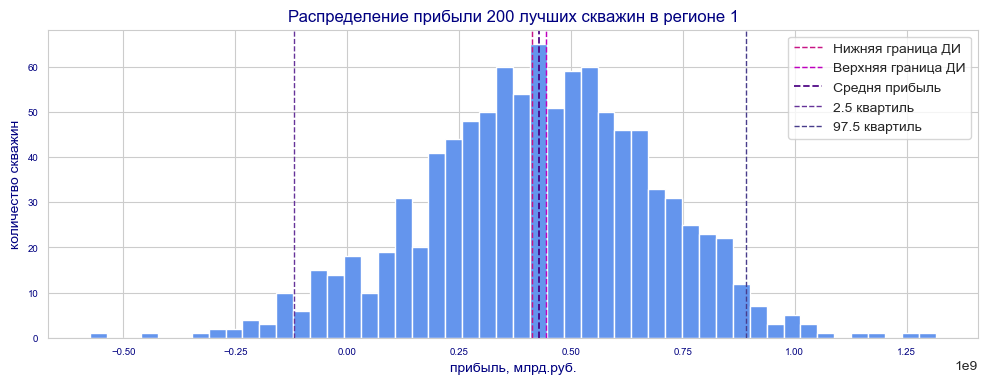

------------------------------------------------------------------------------------------------------------------------------------------------------
 Для региона 2 
 - средняя прибыль скважины из 200 лучиших скважин составляет 42.60 млн.руб.
- суммарная прибыль 200 скважин в данном регионе будет составлять 8,520.65 млн.руб
- риск убытка в данном регионе составляет 1.40%
- с вероятностью 95% прибыль в данном регионе будет составлять от 3.39 до 80.81 млн.руб
- 95% доверительный интервал находится в диапазоне 41.35 - 43.85 млн.руб.
- доля прибыльных скважин составляет 98.60%, средняя прибыль по таким скважинам составляет 43.33 млн. руб.
- доля убыточных скважин составляет 1.40%, средний убыток по таким скважинам составляет -8.24 млн. руб.


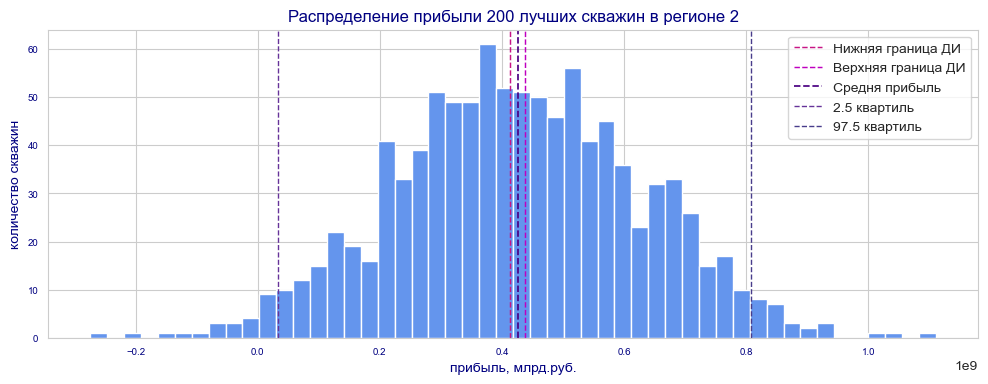

------------------------------------------------------------------------------------------------------------------------------------------------------
 Для региона 3 
 - средняя прибыль скважины из 200 лучиших скважин составляет 34.51 млн.руб.
- суммарная прибыль 200 скважин в данном регионе будет составлять 6,902.48 млн.руб
- риск убытка в данном регионе составляет 9.40%
- с вероятностью 95% прибыль в данном регионе будет составлять от -15.21 до 91.14 млн.руб
- 95% доверительный интервал находится в диапазоне 32.84 - 36.18 млн.руб.
- доля прибыльных скважин составляет 90.60%, средняя прибыль по таким скважинам составляет 39.43 млн. руб.
- доля убыточных скважин составляет 9.40%, средний убыток по таким скважинам составляет -12.88 млн. руб.


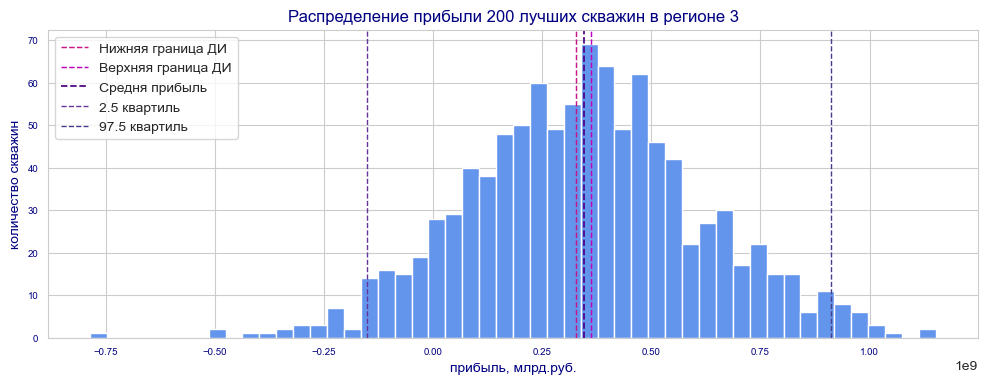

------------------------------------------------------------------------------------------------------------------------------------------------------


In [311]:
regions = ['1', '2', '3']
profit_results = []
for region in regions:
    # для сэмплирования сформируем датафрейм с реальными и прогнозными данными по региону
    targets = pd.DataFrame(columns=['true', 'predict'])
    targets['true'] = targets_true_predict[region][0]
    targets['predict'] = targets_true_predict[region][1]
    earnings = []
    a = []
    for i in range (1000):
        targets_subsample = targets.sample(WELL_NUM, replace=True, random_state=RANDOM_STATE)
        earnings.append(profit(targets_subsample, BEST_WELL_NUM))
    earnings=pd.Series(earnings)
    earnings_mean = earnings.mean() / 10e6
    earnings_total = earnings_mean * 200
    # доверительный интервал
    confidence_interval = st.t.interval(0.95, len(earnings)-1, loc=np.mean(earnings), scale=st.sem(earnings))
    lower = earnings.quantile(0.025) / 10e6
    upper = earnings.quantile(0.975) / 10e6
    # прибыльные и убыточные скважины
    risk = (earnings < 0).mean()
    loss_well = []
    profit_well = []
    loss_well_num = 0
    profit_well_num = 0
    for i in earnings:
        if i < 0:
            loss_well.append(i)
            loss_well_num += 1
        else:
            profit_well.append(i)
            profit_well_num +=1
    
    # добавляем результаты в лист
    profit_results.append([region, earnings_mean, earnings_total, \
                           lower, upper, \
                           confidence_interval[0]/10e6, \
                           confidence_interval[1]/10e6, \
                           loss_well_num / len(earnings)])
                                                         
    # выведем результаты расчетов
    print('\u001b[34;5;1m', f'Для региона {region}', '\u001b[0m')
    print('\u001b[38;5;19m', f'- средняя прибыль скважины из {BEST_WELL_NUM} лучиших скважин составляет {earnings_mean:0,.2f} млн.руб.')
    print(f'- суммарная прибыль 200 скважин в данном регионе будет составлять {earnings_total:0,.2f} млн.руб')
    print(f'- риск убытка в данном регионе составляет {risk:.2%}')
    print(f'- с вероятностью 95% прибыль в данном регионе будет составлять от {lower:0,.2f} до {upper:0,.2f} млн.руб')
    print(f'- 95% доверительный интервал находится в диапазоне {confidence_interval[0]/10e6:0,.2f} - {confidence_interval[1]/10e6:0,.2f} млн.руб.')
    print(f'- доля прибыльных скважин составляет {profit_well_num / len(earnings):.2%}, средняя прибыль по таким скважинам составляет {sum(profit_well) / profit_well_num /10e6:0,.2f} млн. руб.')
    print(f'- доля убыточных скважин составляет {loss_well_num / len(earnings):.2%}, средний убыток по таким скважинам составляет {sum(loss_well) / loss_well_num / 10e6:0,.2f} млн. руб.')
    
    # визуализируем результаты расчетов
    earnings.plot(kind='hist', bins=50, color = 'cornflowerblue', figsize=(12, 4))
    plt.title(f'Распределение прибыли 200 лучших скважин в регионе {region}', color = 'navy')
    plt.axvline(confidence_interval[0], color='mediumvioletred', linestyle='--', label='Нижняя граница ДИ', linewidth=1.05)
    plt.axvline(confidence_interval[1], color='m', linestyle='--', label='Верхняя граница ДИ', linewidth=1.05)
    plt.axvline(earnings.mean(), color='indigo', linestyle='--', label='Средня прибыль', linewidth=1.25)
    plt.axvline(earnings.quantile(0.025), color='rebeccapurple', linestyle='--', label='2.5 квартиль', linewidth=1.)
    plt.axvline(earnings.quantile(0.975), color='darkslateblue', linestyle='--', label='97.5 квартиль', linewidth=1.)
    plt.legend()
    plt.xlabel('прибыль, млрд.руб.', color = 'navy')
    plt.xticks(color='navy', fontsize=7)
    plt.ylabel('количество скважин', color = 'navy')
    plt.yticks(color='navy', fontsize=7)
    plt.show()
    print('\x1b[1;03;34m' + '--'*75 + '\x1b[0m')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что для подсчета доверительного интервала использовался именно метод квантилей!
</div>


<div class="alert alert-block alert-info">

<b>Совет: </b> Риск можно было найти чуть проще: `(values < 0).mean()`, если объект типа pandas Series или numpy array.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> я понимаю, что так можно, но я хотела еще посмотреть и средний убыток по таким скважинам, и соответсвенно среднюю прибыль по доходным скважинам 
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> дополнила код строкой расчета риска как ты предложил, хотя считаю, что риск все же немного по другому считается, но, в условии проекта никаких уточнений не дано.
</div>

In [314]:
profit_results_conso = pd.DataFrame(data=profit_results, columns=['region', 'mean_well_profit', 'total_profit', \
                                                                  '2.5_quartile', '97.5_quartile', \
                                                                  'confidence_interval_low', 'confidence_interval_up', \
                                                                 'risk'])
profit_results_conso = profit_results_conso.sort_values(by='mean_well_profit', ascending=False)
profit_results_conso.style.hide().set_caption("Прибыль 200 лучших скважин") \
                    .format({'mean_well_profit': '{:.2f}', 'total_profit': '{:,.2f}', \
                             '2.5_quartile': '{:.2f}', '97.5_quartile': '{:.2f}', \
                             'confidence_interval_low': '{:.2f}', 'confidence_interval_up': '{:.2f}', \
                             'risk': '{:.2%}'}) \
                    .set_table_styles([{'selector': 'caption','props': [('color', 'navy'),('font-size', '16px'), ('font-weight', 'bold')]}])

region,mean_well_profit,total_profit,2.5_quartile,97.5_quartile,confidence_interval_low,confidence_interval_up,risk
1,42.86,"8,571.52",-11.78,89.15,41.25,44.47,6.00%
2,42.60,"8,520.65",3.39,80.81,41.35,43.85,1.40%
3,34.51,"6,902.48",-15.21,91.14,32.84,36.18,9.40%


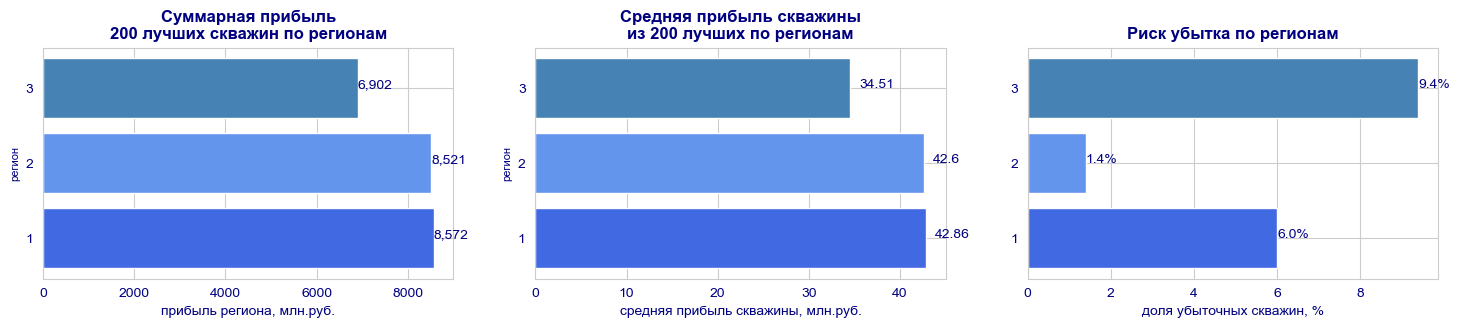

In [316]:
x = profit_results_conso['region']
a = profit_results_conso['total_profit']
b = profit_results_conso['mean_well_profit']
c =  (profit_results_conso['risk']*100).round(2)

plt.figure(figsize=(18, 3))
ax1 = plt.subplot(1, 3, 1)
ax1.barh(x, a, color = ['royalblue','cornflowerblue', 'steelblue'])
plt.title('Суммарная прибыль\n200 лучших скважин по регионам', fontsize=12, fontweight='bold', color='navy')
plt.xlabel('прибыль региона, млн.руб.', color = 'navy', fontsize=10)
plt.ylabel('регион', fontsize=8, color='navy')
plt.tick_params(colors='navy', which='both')
for i, v in enumerate(round(a,2)):
    ax1.text(v, i, f"{v:,.0f}", 
            color = 'navy')
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax2.barh(x, b, color = ['royalblue','cornflowerblue', 'steelblue'])
plt.title('Средняя прибыль скважины\nиз 200 лучших по регионам', fontsize=12, fontweight='bold', color='navy')
plt.xlabel('средняя прибыль скважины, млн.руб.', color = 'navy', fontsize=10)
plt.ylabel('регион', fontsize=8, color='navy')
plt.tick_params(colors='navy', which='both')
for i, v in enumerate(round(b,2)):
    ax2.text(v + 1, i, str(v), 
            color = 'navy')
    
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
ax3.barh(x, c, color = ['royalblue','cornflowerblue', 'steelblue'])
plt.title('Риск убытка по регионам', fontsize=12, fontweight='bold', color='navy')
plt.xlabel('доля убыточных скважин, %', color = 'navy', fontsize=10)
plt.tick_params(colors='navy', which='both')
for i, v in enumerate(c):
    ax3.text(v, i, f"{v/100:.1%}", 
            color = 'navy')

plt.show()

### Резюме

<font color='Darkblue'>✔️ С учетом размера бюджета на разработку и стоимости продукта, <b>безубыточной  может являться разработка скважины, объем запасов которой составляет 111.11 тыс.баррелей.</b><br>&nbsp;&nbsp;&nbsp;<b>- по всем регионам среднее значение запасов скважины ниже установленного показателя безубыточности</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->> наибольший средний запас скважины в 3м регионе - 95.0 тыс.баррелей<br>&nbsp;&nbsp;&nbsp;<b>-  во всех регионах пристутсвуют скважины с объемом запасов, превышающем безубыточный</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->> наибольшая доля безубыточных скважин - 38.18% - приходится на регион 3, где выявлено 38,173 таких скважин.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->> меньше всего безубыточных скважин во 2 регионе - 16.54%<br>
<font color='Darkblue'>✔️ Расчет прибыли и рисков по регионам показал, что<br>&nbsp;&nbsp;&nbsp;<b>- наибольшая суммарная прибыль 200 лучших скважин (12.9 млрд рублей) и средняя прибыль скважины из 200 лучших скважин (64.65 млн. рублей) в перво регионе</b>, с 95% доверительным интервалом в диапазоне от 62.30 до 66.04 млн.рублей<b><br>&nbsp;&nbsp;&nbsp;<b>- наименьший уровень риска убытка среди отобранных скважин 0.6% отмечен во втором регионе</b><br>
<font color='Darkblue'>✔️ Таким образом по итогам анализа прибыльности скважин регионов <b>для разработки можно рекомендовать первый регион</b>, вероятность убытка в котором низкая, а средняя доходность отобранных лучших скважин и суммарная прибыль по скважинам региона самая высокая.

## Выводы

<font color='Darkblue'><b>I. <i> Исходные данные</b></i><br>
<font color='Darkblue'>Для исследования предоставлено 3 датасэта, характеризующих пробы в скважинах трех регионов</u><br> &nbsp;&nbsp;&nbsp;<b>- все датасэты содержат по 5 колонок и 100,000 записей, пропусков в данных нет </b><br> &nbsp;&nbsp;&nbsp;<b>- `id`</b> — уникальный идентификатор скважины, в датасете `df_1` предоставлены данные о 99,990 уникальных скважинах, в датасетах `df_2` и `df_3` предоставлены данные о 99,996 уникальных скважинах<br> &nbsp;&nbsp;&nbsp;<b>- `f0`, `f1`, `f2`</b> — характеристики скважин<br> &nbsp;&nbsp;&nbsp;<b>- `product`</b> — объем запасов<br>

<font color='Darkblue'><b>II. <i> Анализ данных</b></i><br>
<font color='Darkblue'>&nbsp;&nbsp;&nbsp;- распределение и корреляция признаков f0, f1, f2 и product в данных по регионам существенно различается:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> нормальное распределение характерно f0 f1 для 2 региона, f1 и f2 для 3 региона и f2 для 1 региона,<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> дискретное распределение показали f2 и product для 2 региона<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -> бимодальное распределение у признака f0 2 региона<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> мультимодальное распределение показали данные по признакам f0, f1 и product для 1 региона и product 3 региона<br>&nbsp;&nbsp;&nbsp;- по распределению, диапазону значений, медианному и среднему значениям объемов запасов значения сопоставимы в 1 и 3 регионах

<font color='Darkblue'><b>III. <i> Модель прогноза запасов</b></i><br>
<font color='Darkblue'>- <b>наибольший средний объем запасов по скважинам - 94.82 тыс.барреля - прогнозируется по кважинам 3 регион</b>, но, при этом и все метрики качества модели самые "плохие", что означает, что <b>в данном регионе самый высокий риск ошибки прогноза</b><br>- <b>самый низкий уровень прогноза среднего объема запасов по скважинам - 69.23 тыс.барреля - прогнозируется по скважинам 2 региона</b>, но и качество модели, в противовес модели по третему региону, высокое, а значит и <b>риск ошибки невелик.

<font color='Darkblue'><b>IV. <i> Прибыльность и риски добычи по регионам</b></i><br>
<font color='Darkblue'>- с учетом размера бюджета на разработку и стоимости продукта, <b>безубыточной  может являться разработка скважины, объем запасов которой составляет не менее 111.11 тыс.баррелей.</b><br>&nbsp;&nbsp;&nbsp;<b>-> по всем регионам среднее значение запасов скважины ниже установленного показателя безубыточности</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->> наибольший средний запас скважины в 3м регионе - 95.0 тыс.баррелей<br>&nbsp;&nbsp;&nbsp;<b>->  во всех регионах пристутсвуют скважины с объемом запасов, превышающем безубыточный</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->> наибольшая доля безубыточных скважин - 38.18% - приходится на регион 3, где выявлено 38,173 таких скважин.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;->> меньше всего безубыточных скважин во 2 регионе - 16.54%<br>
<font color='Darkblue'><b>- наибольшая суммарная прибыль 200 лучших скважин (12.9 млрд рублей) и средняя прибыль скважины из 200 лучших скважин (64.65 млн. рублей) в первом регионе</b>, с 95% доверительным интервалом в диапазоне от 62.30 до 66.04 млн.рублей<br>&nbsp;&nbsp;&nbsp; <b>- наименьший уровень риска убытка среди отобранных скважин 0.6% отмечен во втором регионе</b><br><br>
<font color='Darkblue'>✔️ По итогам анализа прибыльности скважин регионов <b><u> для разработки можно рекомендовать первый регион</b></u>, вероятность убытка в котором низкая, а средняя доходность отобранных лучших скважин и суммарная прибыль по скважинам региона самая высокая.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован